In [21]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import sys
from typing import List
import numpy as np
from copy import deepcopy
import joblib
from pprint import pprint
from sklearn.preprocessing import normalize
from math import ceil
import cortex
from neuro import config
from collections import defaultdict
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests
from neuro import flatmaps_helper
from neuro.flatmaps_helper import load_flatmaps
import neuro.sasc.viz
from neuro import analyze_helper
import nibabel as nib
neurosynth_compare = __import__('04_neurosynth_compare')
import neurosynth
from neuro.features.questions.gpt4 import QS_35_STABLE
from neuro.features import qa_questions

config.setup_freesurfer()
N_SURVEY_RESPONSES = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### ensemble (non-gpt-4) feats each run one at a time

In [ ]:
rr_all = pd.read_pickle(join(config.RESULTS_DIR_LOCAL, 'results_full_oct17.pkl'))
r = rr_all[rr_all.ndelays == 4]
r = r[r.pc_components == 100]
r = r[r.feature_space == 'qa_embedder']
r = r[r.qa_questions_version == 'v3_boostexamples_merged']
r = r[r.qa_embedding_model == 'ensemble2']
r = r[r.single_question_idx >= 0]
r = r[r.feature_selection_alpha == -1]

In [ ]:
ravg = r.groupby(['single_question_idx'])[
    ['corrs_test_mean']].mean().reset_index()
qs = qa_questions.get_merged_questions_v3_boostexamples()
ravg['question'] = ravg['single_question_idx'].apply(lambda i: qs[i])
ravg['q_selected'] = ravg['question'].apply(lambda q: q in QS_35_STABLE)
ravg['question_abbrev'] = ravg['question'].apply(
    analyze_helper.abbrev_question)

In [ ]:
# ravg.to_pickle('corrs_df/single_question_corrs.pkl')

In [ ]:
r_selected = ravg[ravg.q_selected]
r_unselected = ravg[~ravg.q_selected]
plt.figure(figsize=(6, 3))
sns.histplot(r_unselected.corrs_test_mean, label='Unselected', color="C1")
sns.histplot(r_selected.corrs_test_mean, label='Selected 35', color="C0")
plt.legend()
plt.xlabel('Test correlation using single-question model')
plt.ylabel('Question count')
print('means', r_selected.corrs_test_mean.mean(),
      r_unselected.corrs_test_mean.mean())
neuro.viz.savefig(
    'monosemantic/single_question_perf_hists.pdf', bbox_inches='tight')

In [6]:
with pd.option_context('display.max_colwidth', None,
                       'display.max_rows', None):
    display(ravg[~ravg.q_selected].sort_values('corrs_test_mean', ascending=False)
            [['question_abbrev', 'corrs_test_mean']].head(20))
print(
    ravg[~ravg.q_selected]
    .sort_values('corrs_test_mean', ascending=False)[['question_abbrev', 'corrs_test_mean']]
    .head(15).to_latex(float_format="%.3f", index=False)
)
print(
    ravg[~ravg.q_selected]
    .sort_values('corrs_test_mean', ascending=False)[['question_abbrev', 'corrs_test_mean']]
    .tail(15).to_latex(float_format="%.3f", index=False)
)

,question_abbrev,corrs_test_mean
340,...contain words with strong visual imagery?,0.035637
450,...part of a narrative?,0.032772
507,...describe an act of communication or interaction with others?,0.030412
563,...describe a an interpersonal misunderstanding or dispute?,0.030407
514,...describe an emotional response to a specific event?,0.030288
284,...mention of a physical object or item?,0.030052
592,...involve a social or interpersonal interaction?,0.029991
600,...involve the description of an emotional response?,0.029959
287,...mention of a scientific fact or concept?,0.029715
562,...describe a an emotional reaction to a surprise or unexpected event?,0.029518


\begin{tabular}{lr}
\toprule
question_abbrev & corrs_test_mean \\
\midrule
...contain words with strong visual imagery? & 0.036 \\
...part of a narrative? & 0.033 \\
...describe an act of communication or interaction with others? & 0.030 \\
...describe a an interpersonal misunderstanding or dispute? & 0.030 \\
...describe an emotional response to a specific event? & 0.030 \\
...mention of a physical object or item? & 0.030 \\
...involve a social or interpersonal interaction? & 0.030 \\
...involve the description of an emotional response? & 0.030 \\
...mention of a scientific fact or concept? & 0.030 \\
...describe a an emotional reaction to a surprise or unexpected event? & 0.030 \\
...use irony or sarcasm? & 0.029 \\
...contain a first-person narrative? & 0.029 \\
...contain a description of an interaction that led to a misunderstanding or conflict? & 0.029 \\
...first-person pronoun in the input? & 0.029 \\
...include a recounting of an impactful or emotional dialogue? & 0.029 \\
\bo

### load survey results

In [25]:
survey_results = pd.read_csv('survey_results.csv')
# set first column name to 'question_abbrev'
survey_results.rename(columns={survey_results.columns[0]: 'question_abbrev'}, inplace=True)

# apply lambda function to col names
survey_results.columns = [x[:x.index('(')].strip() if '(' in x else x for x in survey_results.columns]
# add question mark to question_abbrev

def remove_parens(s):
    if '(' in s and ')' in s:
        # remove everything from the first '(' to the first ')'
        # and return the rest of the string
        s = s[:s.index('(')] + s[s.index(')') + 1:]
    return s

survey_results['question_abbrev'] = survey_results['question_abbrev'].apply(
    remove_parens)
survey_results['question_abbrev'] = survey_results['question_abbrev'].apply(
    lambda x: x.strip() + '?' if not x.strip().endswith('?') else x)

RENAME_DICT = {
    '...contain numbers?': '...contain a number?',
    "...are reflective, involving self-analysis or introspection?":"...reflective, involving self-analysis or introspection?",
    "...are related to a specific industry or profession?":
        "...related to a specific industry or profession?",
     "...is abstract rather than concrete?":
        "...abstract rather than concrete?",
    "...describe an interpersonal misunderstanding or dispute?":
        "...describe a an interpersonal misunderstanding or dispute?",
     "...cointain first-person pronoun?":
        "...first-person pronoun in the input?",
    "...are part of a legal document or text?":
        "...part of a legal document or text?",
    '...include a description about dialogue?':    
        '...include dialogue?',
    '...describe an educational lesson or class?':
        '...educational lesson or class described?',
}
# rename columns according to RENAME_DICT
survey_results['question_abbrev'] = [RENAME_DICT.get(x, x) for x in survey_results['question_abbrev']]


# merge with ravg on question_abbrev
merged = ravg.merge(survey_results, on='question_abbrev', how='right')

# for any duplicate question_abbrev, take the one where q_selected is True
merged = merged.sort_values('q_selected', ascending=False).drop_duplicates(
    'question_abbrev').sort_index()

merged['Standard Error'] = merged['Standard Deviation'] / np.sqrt(N_SURVEY_RESPONSES)
merged['legend'] = merged['q_selected'].apply(
    lambda x: 'Selected 35' if x else 'Unselected')
merged.sort_values('corrs_test_mean', ascending=False, inplace=True)

In [23]:
# # merged = merged[['question_abbrev', 'Average', 'Standard Deviation', 'corrs_test_mean']].sort_values(by='corrs_test_mean', ascending=False)
# with pd.option_context('display.max_colwidth', None,
#                        'display.max_rows', None):
#     display(merged[merged.corrs_test_mean.isna()]['question_abbrev'])
#     # display(ravg.question_abbrev)

In [27]:
import dvu
dvu.set_style()

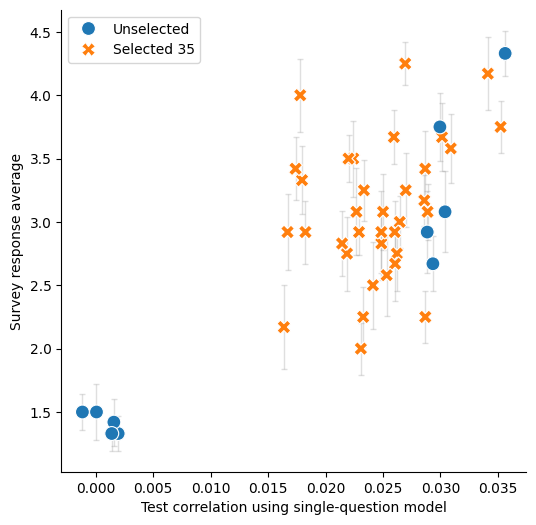

In [28]:
plt.figure(figsize=(6, 6))
plt.errorbar(merged['corrs_test_mean'], merged['Average'],
             yerr=merged['Standard Error'], fmt='none', capsize=2,
             elinewidth=1, alpha=0.25, color='gray', zorder=-11)
sns.scatterplot(data=merged, x='corrs_test_mean', y='Average',
                hue='legend', style='legend', s=100, alpha=1)
plt.xlabel('Test correlation using single-question model')
plt.ylabel('Survey response average')
plt.legend(title='')
plt.show()

In [32]:
merged[['question_abbrev']].to_csv('survey_results_merged.csv', index=False)

# The rest of this is experimental, never ran it properly...

### gpt-4 feats

In [ ]:
rr = pd.read_pickle(join(config.RESULTS_DIR_LOCAL, 'oct17_tmp.pkl'))

In [ ]:
subject = 'S02'
r = rr
r = r[r.subject == subject]
r = r[r.use_added_wordrate_feature == False]
r = r[r.feature_space == 'qa_embedder']
r = r[r.qa_embedding_model == 'gpt4']
r = r[r.qa_questions_version.str.endswith('?')]  # individual question
r = r[r.ndelays == 4]

In [ ]:
df_selected = pd.read_pickle('../notebooks/monosemantic_df.pkl')

In [ ]:
corrs_dicts = {}
for subj in r.subject.unique():
    r_subj = r[r.subject == subj]
    q_to_corrs = r_subj.set_index(
        'qa_questions_version').corrs_test.to_dict()

    vox_to_q = df_selected[df_selected.subject == 'UT' + subj]
    vox_to_q_dict = vox_to_q.set_index('voxel_idx').question.to_dict()

    corrs = np.zeros(len(vox_to_q_dict))
    for i, (vox, question) in enumerate(tqdm(vox_to_q_dict.items())):
        corrs[i] = q_to_corrs[question][i]

In [ ]:
q_to_corrs

In [ ]:
r_

In [ ]:
len(vox_to_question_dict)

In [ ]:

r_subj.set_index('qa_questions_version')